<a href="https://colab.research.google.com/github/NandiniLReddy/Florence2Inference/blob/main/Florence2_sample_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Florence-2-large sample usage deployed by Nandini Lokesh Reddy


In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
%matplotlib inline

In [3]:
pip install timm flash_attn einops

In [4]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

## define the prediction function

In [5]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image

In [6]:
url = "https://t3.ftcdn.net/jpg/03/90/32/16/360_F_390321632_gbpPQS44ZlUOJ6DgWyDxzUAKEfmC5xec.jpg"
image = Image.open(requests.get(url, stream=True).raw)

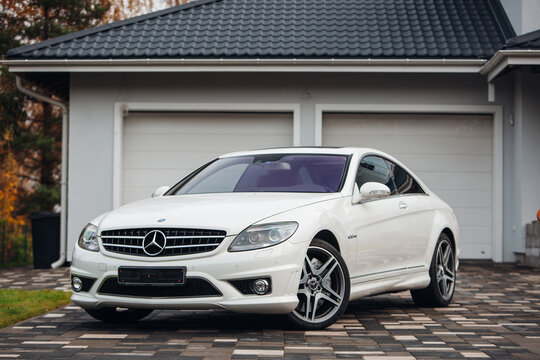

In [7]:
image

### Caption

In [8]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': '\nA white car parked in front of a garage.\n'}

In [9]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': '\nThe image shows a white Mercedes-Benz CL63 AMG Coupe parked in front of a house, surrounded by lush green grass and trees in the background.\n'}

In [ ]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a sleek, streamlined design. It has two doors on either side of the car, one on top of the other, and a small window on the front. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}

### Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [15]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[68.31000518798828, 145.62001037597656, 461.4300231933594, 330.3000183105469], [77.49000549316406, 223.02000427246094, 99.6300048828125, 251.82000732421875], [151.47000122070312, 185.5800018310547, 171.45001220703125, 197.4600067138672], [270.80999755859375, 238.1400146484375, 351.27001953125, 330.3000183105469], [409.59002685546875, 232.74000549316406, 457.1100158691406, 307.260009765625], [83.97000122070312, 307.6200256347656, 154.17001342773438, 322.3800048828125]], 'labels': ['car', 'headlight', 'rearview mirror', 'wheel', 'wheel', 'wheel']}}


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

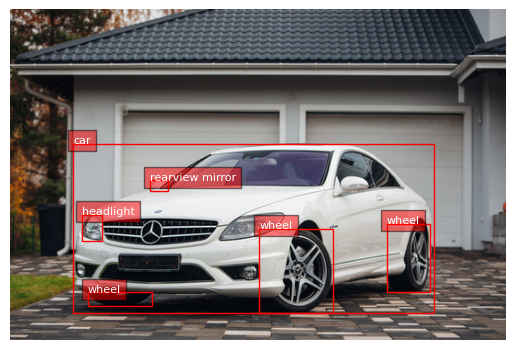

In [17]:
plot_bbox(image, results['<OD>'])

### Referring expression segmentation

Referring expression segmentation results format:
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [12]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[209.79000854492188, 160.02000427246094, 217.8900146484375, 156.0600128173828, 220.5900115966797, 154.98001098632812, 223.8300018310547, 153.90000915527344, 226.53001403808594, 153.1800079345703, 230.85000610351562, 152.10000610351562, 235.7100067138672, 151.02000427246094, 243.8100128173828, 149.94000244140625, 251.91000366210938, 149.22000122070312, 260.5500183105469, 148.13999938964844, 269.7300109863281, 147.0600128173828, 282.69000244140625, 145.98001098632812, 301.59002685546875, 145.260009765625, 322.6500244140625, 145.260009765625, 357.75, 145.98001098632812, 369.6300048828125, 147.0600128173828, 374.4900207519531, 148.13999938964844, 377.7300109863281, 149.22000122070312, 380.4300231933594, 149.94000244140625, 383.6700134277344, 151.02000427246094, 394.4700012207031, 156.0600128173828, 397.71002197265625, 158.22000122070312, 400.4100036621094, 160.02000427246094, 403.6500244140625, 162.1800079345703, 407.4300231933594, 165

In [13]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

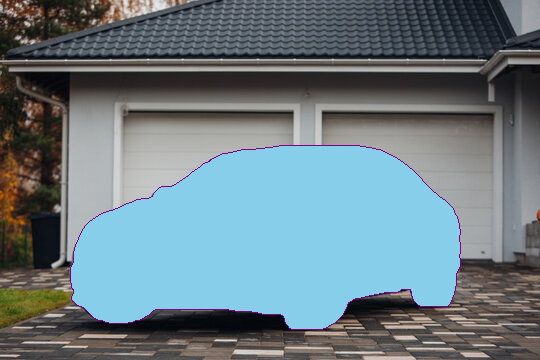

In [14]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

## ocr related tasks

In [18]:
url = "https://m.media-amazon.com/images/I/71i7RZM8pML._AC_UF1000,1000_QL80_.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

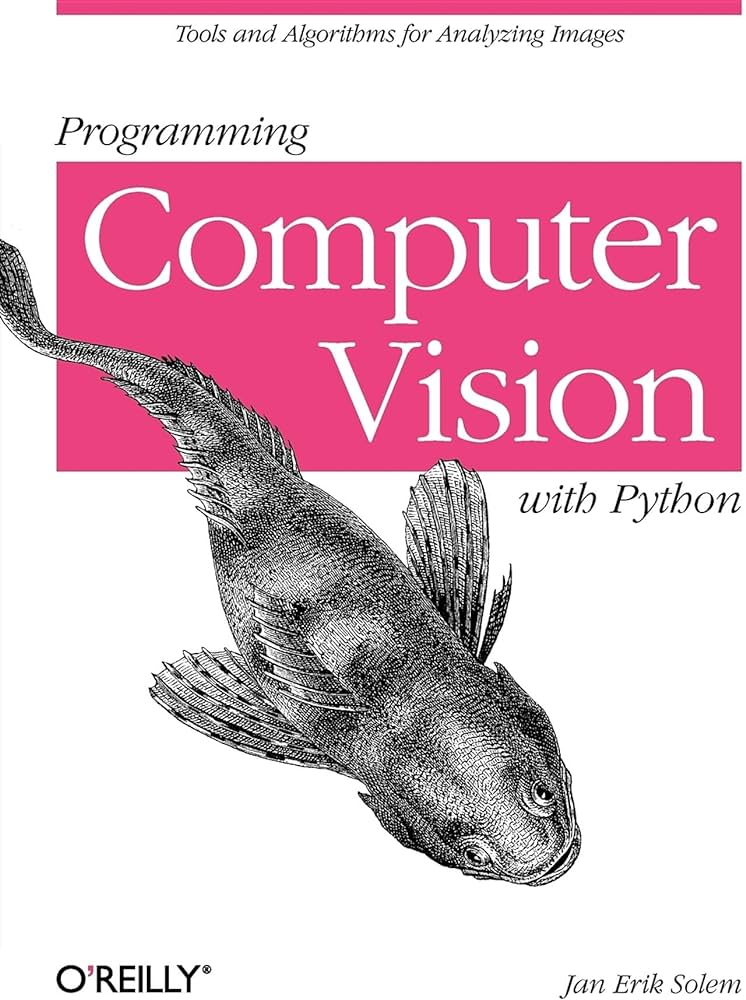

In [19]:
image

In [20]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': "\nTools and Algorithms for Analyzing ImagesProgrammingComputerVisionwith PythonO'REILLY®Jan Erik Solem\n"}

In [21]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[174.1909942626953, 20.5, 626.2669677734375, 21.5, 626.2669677734375, 50.5, 174.1909942626953, 48.5], [54.084999084472656, 113.5, 310.708984375, 115.5, 310.708984375, 158.5, 54.084999084472656, 156.5], [83.17900085449219, 180.5, 719.5169677734375, 191.5, 717.2789916992188, 315.5, 83.17900085449219, 309.5], [318.9150085449219, 335.5, 715.7869873046875, 335.5, 715.7869873046875, 449.5, 318.9150085449219, 449.5], [515.8590087890625, 480.5, 743.3889770507812, 480.5, 743.3889770507812, 522.5, 515.8590087890625, 522.5], [557.635009765625, 972.5, 744.135009765625, 971.5, 744.135009765625, 999.5, 557.635009765625, 999.5]], 'labels': ['</s>Tools and Algorithms for Analyzing Images', 'Programming', 'Computer', 'Vision', 'with Python', 'Jan Erik Solem']}}


In [22]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)


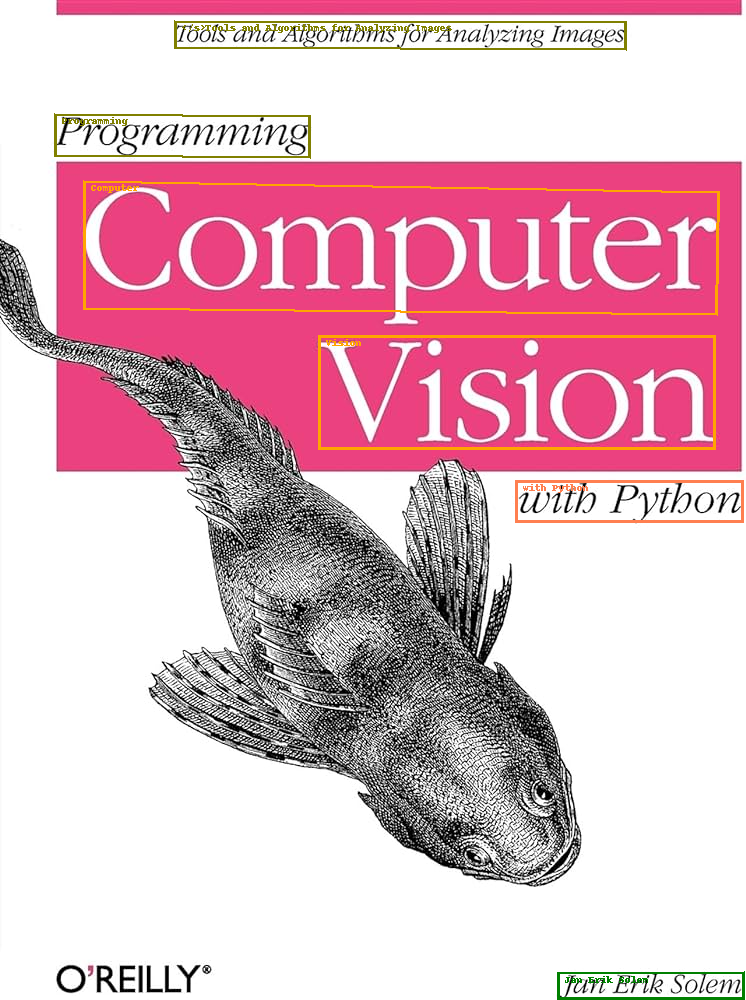

In [23]:
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])